In [3]:
import math
import time
import os
import glob
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from PIL import Image
from sklearn.metrics import confusion_matrix



import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable

import torchvision
import torchvision.datasets as datasets
import torchvision.models as models
import torchvision.transforms as transforms
from helper import * #helper functions



In [6]:
DATA_DIR = '/content/drive/MyDrive/data/' #my img data set directory
sz = 224 # for resize my img
batch_size = 32

In [8]:
trn_dir = f'{DATA_DIR}Train_dataset'
val_dir = f'{DATA_DIR}val'

In [12]:
train_ds = datasets.ImageFolder(trn_dir)

In [14]:
train_ds.class_to_idx

{'Train_negative': 0, 'Train_positive': 1}

In [17]:
tfms = transforms.Compose([
    transforms.Resize((sz, sz)),  # PIL Image
    transforms.ToTensor(),        # Tensor
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

train_ds = datasets.ImageFolder(trn_dir, transform=tfms)
valid_ds = datasets.ImageFolder(val_dir, transform=tfms)

In [18]:
len(train_ds), len(valid_ds)

(15793, 1000)

In [22]:
train_dl = torch.utils.data.DataLoader(train_ds,
                                       batch_size=batch_size,
                                       shuffle=True,
                                       num_workers=2)

valid_dl = torch.utils.data.DataLoader(valid_ds,
                                       batch_size=batch_size,
                                       shuffle=False,
                                       num_workers=2)

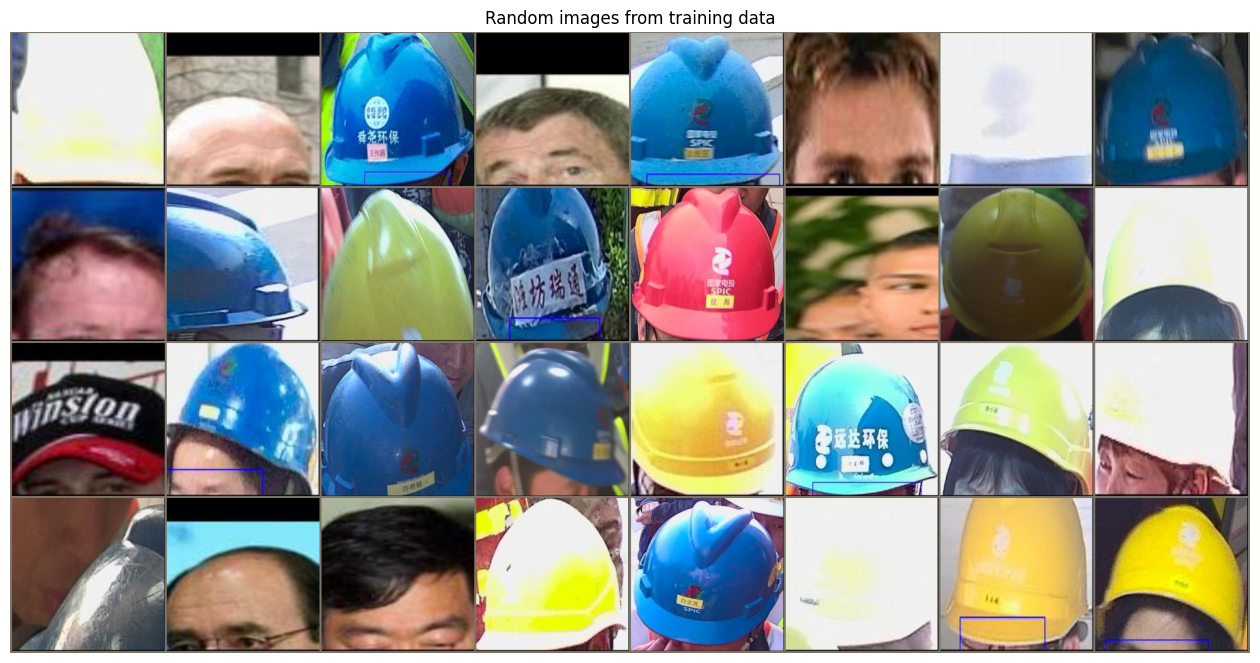

In [23]:
inputs, targets = next(iter(train_dl))
out = torchvision.utils.make_grid(inputs, padding=3)
plt.figure(figsize=(16, 12))
imshow(out, title='Random images from training data')

In [24]:
class SimpleCNN(nn.Module): # just 2 layer of convolution

    def __init__(self):
        super(SimpleCNN, self).__init__()

        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=5, padding=2),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )

        self.conv2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=5, padding=2),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )

        self.fc = nn.Linear(56 * 56 * 32, 2)

    def forward(self, x):
        out = self.conv1(x)
        out = self.conv2(out)
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        return out

In [25]:
model = SimpleCNN()


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = model.to(device)

In [26]:
import tensorflow as tf
tf.test.gpu_device_name()

'/device:GPU:0'

In [28]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.002, momentum=0.9)

In [29]:
num_epochs = 10 # first test with 1
losses = []

for epoch in range(num_epochs):
    for i, (inputs, targets) in enumerate(train_dl):
        inputs = inputs.to(device)
        targets = targets.to(device)


        outputs = model(inputs)


        loss = criterion(outputs, targets)
        losses.append(loss.item())


        optimizer.zero_grad()
        loss.backward()


        optimizer.step()


        if (i + 1) % 50 == 0:
            print('Epoch [%2d/%2d], Step [%3d/%3d], Loss: %.4f'
                  % (epoch + 1, num_epochs, i + 1, len(train_ds) // batch_size, loss.item()))

Epoch [ 1/10], Step [ 50/493], Loss: 0.2177
Epoch [ 1/10], Step [100/493], Loss: 0.0002
Epoch [ 1/10], Step [150/493], Loss: 0.0418
Epoch [ 1/10], Step [200/493], Loss: 0.0002
Epoch [ 1/10], Step [250/493], Loss: 0.1304
Epoch [ 1/10], Step [300/493], Loss: 0.0063
Epoch [ 1/10], Step [350/493], Loss: 0.0014
Epoch [ 1/10], Step [400/493], Loss: 0.0230
Epoch [ 1/10], Step [450/493], Loss: 0.0002
Epoch [ 2/10], Step [ 50/493], Loss: 0.0012
Epoch [ 2/10], Step [100/493], Loss: 0.3676
Epoch [ 2/10], Step [150/493], Loss: 0.1279
Epoch [ 2/10], Step [200/493], Loss: 0.0078
Epoch [ 2/10], Step [250/493], Loss: 0.0005
Epoch [ 2/10], Step [300/493], Loss: 0.0012
Epoch [ 2/10], Step [350/493], Loss: 0.0100
Epoch [ 2/10], Step [400/493], Loss: 0.0008
Epoch [ 2/10], Step [450/493], Loss: 0.0000
Epoch [ 3/10], Step [ 50/493], Loss: 0.0000
Epoch [ 3/10], Step [100/493], Loss: 0.0000
Epoch [ 3/10], Step [150/493], Loss: 0.0000
Epoch [ 3/10], Step [200/493], Loss: 0.0003
Epoch [ 3/10], Step [250/493], L

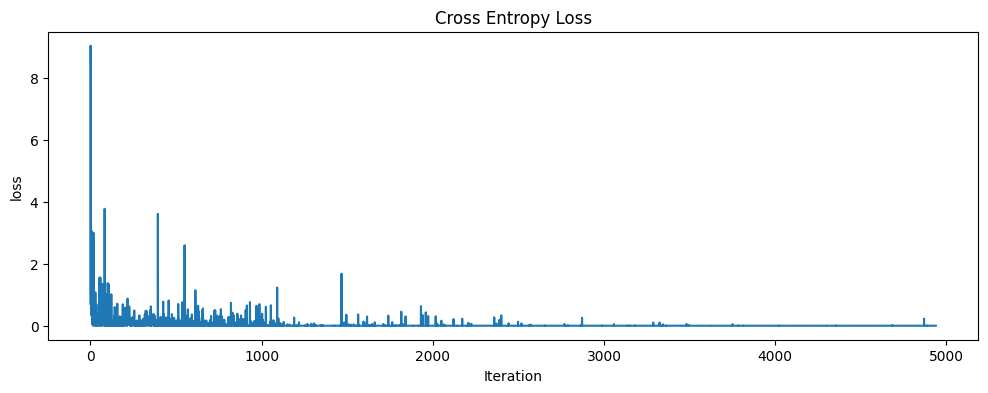

In [30]:
plt.figure(figsize=(12, 4))
plt.plot(losses)
plt.xlabel('Iteration')
plt.ylabel('loss')
plt.title('Cross Entropy Loss')
plt.show()

In [32]:
def evaluate_model(model, dataloader, device):
    model.eval()  # for batch normalization layers
    corrects = 0

    with torch.no_grad():
        for inputs, targets in dataloader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            corrects += (preds == targets.data).sum()

    print('accuracy: {:.2f}'.format(100. * corrects / len(dataloader.dataset)))

In [33]:
evaluate_model(model, valid_dl, device)

accuracy: 97.70


In [34]:
evaluate_model(model, train_dl, device)

accuracy: 100.00


In [36]:
def visualize_model(model, dataloader, device, num_images=6):
    """ Visulaize the prediction of the model on a bunch of random data.
    """
    model.eval()
    images_so_far = 0
    fig = plt.figure(figsize=(10., 8.))

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloader):
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs.data, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(dataloader.dataset.classes[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    return


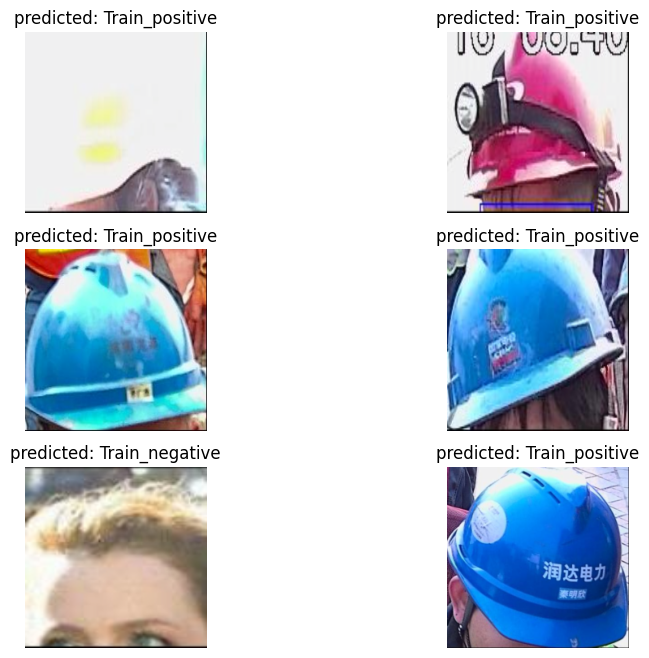

In [37]:
visualize_model(model, train_dl, device)

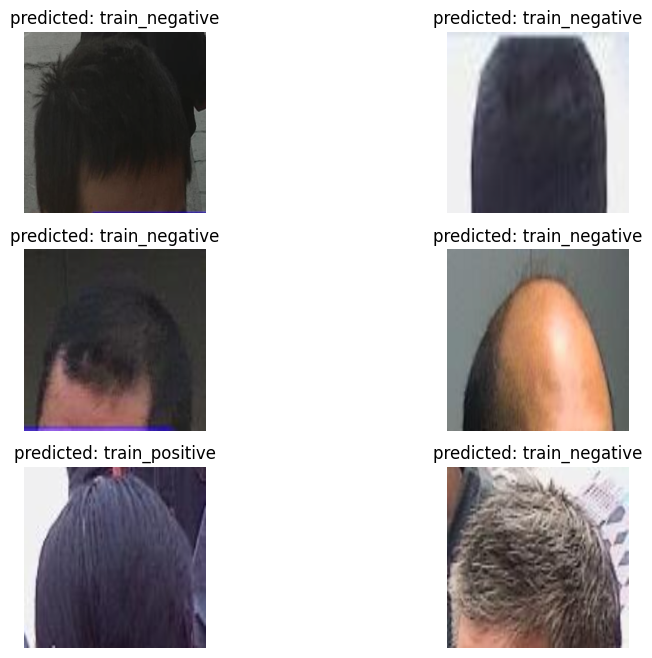

In [40]:
visualize_model(model, valid_dl, device)

In [42]:
def plot_errors(model, dataloader, device):
    model.eval()
    plt.figure(figsize=(12, 24))
    count = 0

    with torch.no_grad():
        for inputs, labels in tqdm(dataloader):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            incorrect_idxs = np.flatnonzero(preds.cpu().numpy() != labels.cpu().numpy())

            for idx in incorrect_idxs:
                count += 1
                if count > 30: break
                ax = plt.subplot(10, 3, count)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(dataloader.dataset.classes[preds[idx]]))
                imshow(inputs.cpu().data[idx])

    plt.show()

    print("{} images out of {} were misclassified.".format(count, len(dataloader.dataset)))



100%|██████████| 32/32 [00:12<00:00,  2.51it/s]


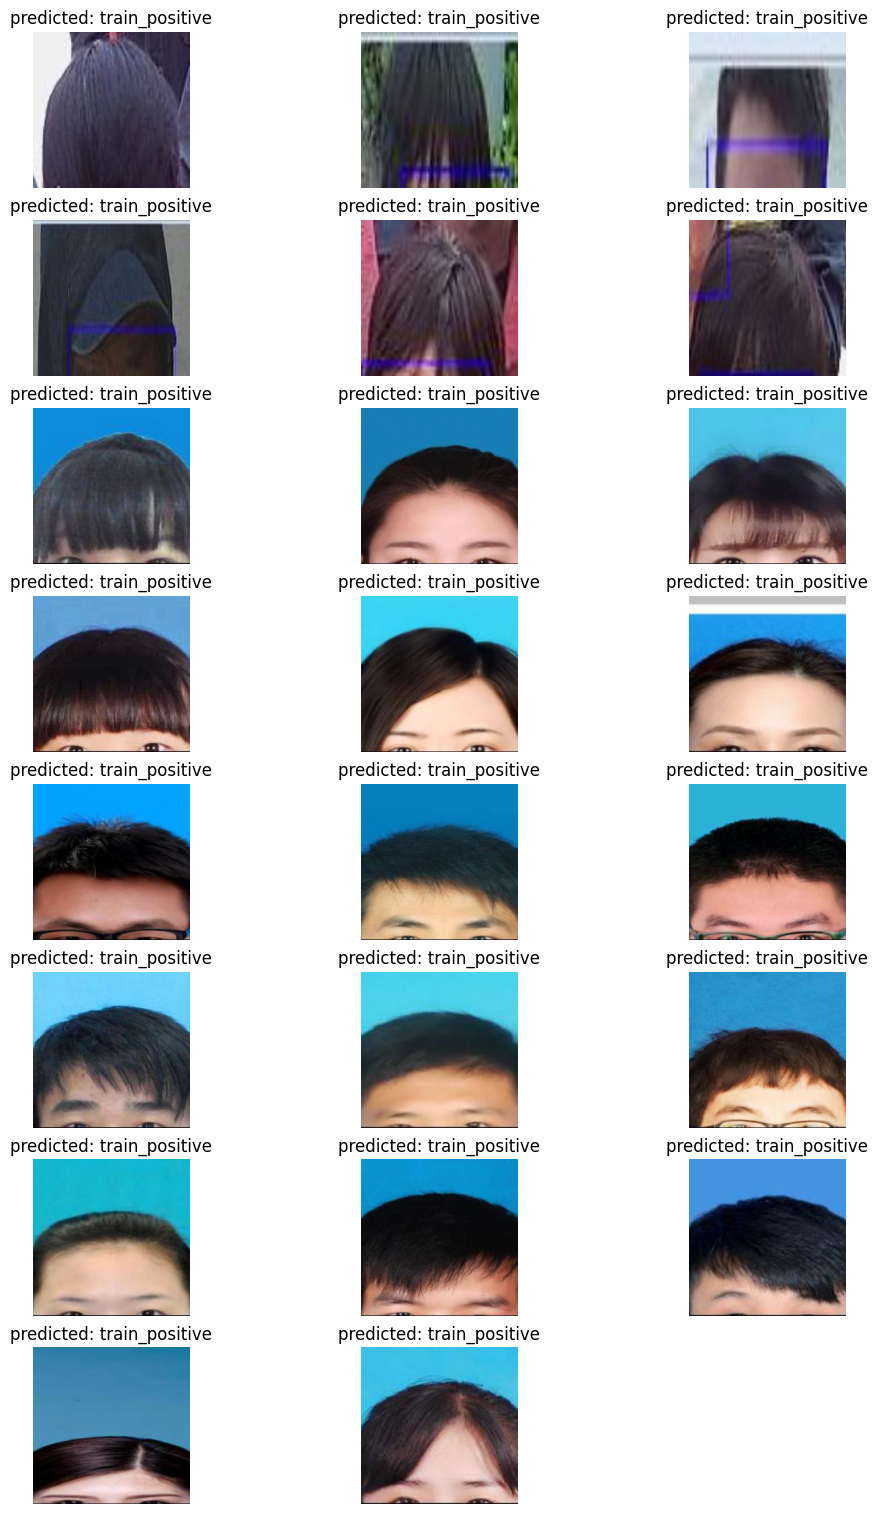

23 images out of 1000 were misclassified.


In [43]:
plot_errors(model, valid_dl, device)

In [48]:
torch.save(model.state_dict(), 'model.pth')